<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/PAGS/Pags_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from keras.metrics import mean_squared_error


In [3]:
url = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/'+
       'TemporalSeries/PAGS/PAGSattempt.csv')

In [4]:
url_data = requests.get(url).content
raw_data = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [5]:
raw_data = raw_data[["Date","Close"]]

In [6]:
raw_data.index = pd.to_datetime(raw_data["Date"])
raw_data.drop("Date", axis = 1, inplace =  True)

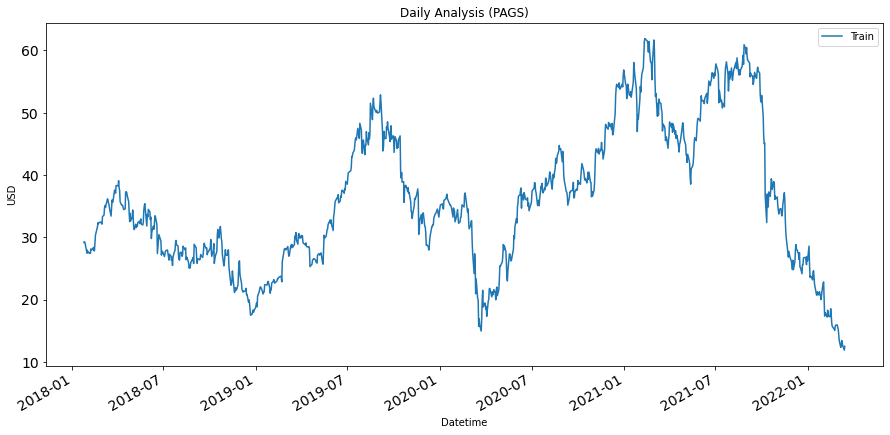

In [7]:
raw_data.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'Train')
plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **SPLITTING DATA:**

In [8]:
SPLIT_PERCENT = 0.80
split = int(SPLIT_PERCENT*len(raw_data))
train = raw_data[:split]
test = raw_data[split:]

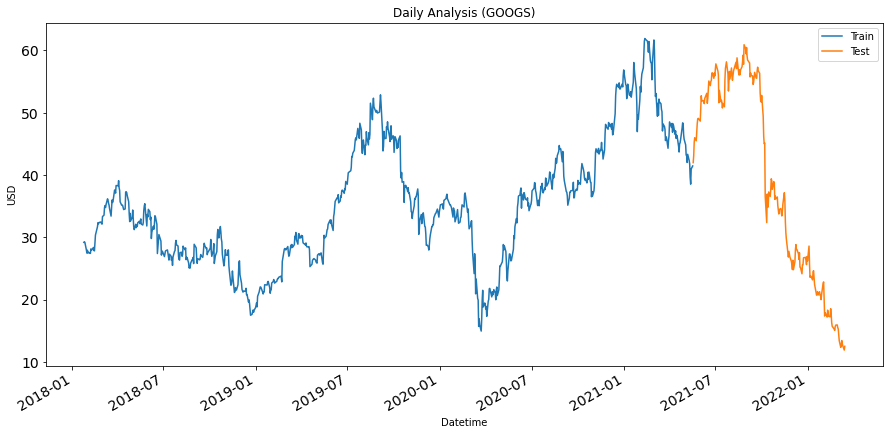

In [9]:
train.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'Test', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

## **PREPARING TRAINING DATA:**

In [10]:
input_train = train.values
input_train = input_train.reshape((-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
input_train = scaler.fit_transform(input_train)

In [11]:
LOOK_BACK = 120
X_train = []
y_train = []

In [12]:
for i in range (LOOK_BACK, len(input_train)):
  X_train.append(input_train[i-LOOK_BACK:i,0])
  y_train.append(input_train[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], LOOK_BACK, 1))

In [13]:
print (X_train.shape[0], y_train.shape[0])

714 714


## **TRAINING LSTM:**

In [15]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True,
                   input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50))
model.add(Dropout(0.3))


model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'rmsprop', loss = 'mse',
                  metrics = ['mse'])

model.fit(X_train, y_train, epochs = 50, batch_size = 32, workers=-1)

Epoch 1/50
23/23 [==============================] - 13s 244ms/step - loss: 0.0476 - mse: 0.0476
Epoch 2/50
23/23 [==============================] - 6s 243ms/step - loss: 0.0186 - mse: 0.0186
Epoch 3/50
23/23 [==============================] - 6s 242ms/step - loss: 0.0180 - mse: 0.0180
Epoch 4/50
23/23 [==============================] - 6s 241ms/step - loss: 0.0178 - mse: 0.0178
Epoch 5/50
23/23 [==============================] - 5s 237ms/step - loss: 0.0156 - mse: 0.0156
Epoch 6/50
23/23 [==============================] - 6s 239ms/step - loss: 0.0132 - mse: 0.0132
Epoch 7/50
23/23 [==============================] - 6s 240ms/step - loss: 0.0131 - mse: 0.0131
Epoch 8/50
23/23 [==============================] - 6s 242ms/step - loss: 0.0132 - mse: 0.0132
Epoch 9/50
23/23 [==============================] - 6s 245ms/step - loss: 0.0123 - mse: 0.0123
Epoch 10/50
23/23 [==============================] - 6s 241ms/step - loss: 0.0092 - mse: 0.0092
Epoch 11/50
23/23 [=============================

## **LSTM in the train dataset**

In [16]:
LSTM_train = model.predict(X_train)
LSTM_train = scaler.inverse_transform(LSTM_train)
LSTM_train = pd.DataFrame(LSTM_train, columns = ['Close'])

In [17]:
LSTM_train["Date"] = train[LOOK_BACK:].index
LSTM_train.index = pd.to_datetime(LSTM_train["Date"])
LSTM_train.drop("Date", axis = 1, inplace =  True)

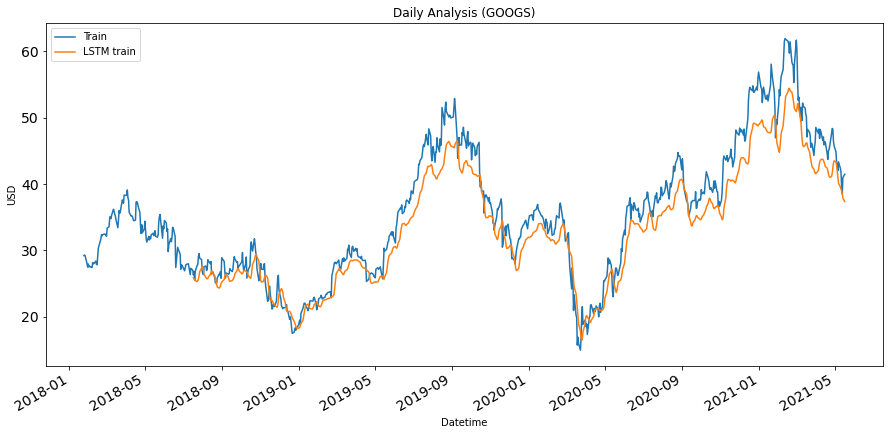

In [18]:
train.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
LSTM_train.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'LSTM train', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

In [19]:
train_mse = np.reshape(train.values, (train.values.shape[0]))
LSTM_train_mse = np.reshape(LSTM_train.values, (LSTM_train.values.shape[0]))
MSE_train = mean_squared_error(train_mse[LOOK_BACK:], LSTM_train_mse)
MSE_train

<tf.Tensor: shape=(), dtype=float32, numpy=11.895635>

## **LSTM in the Test dataset:**

In [20]:
complete_data = raw_data.values
input_test = complete_data[len(complete_data) - len(test) - LOOK_BACK:]
input_test = input_test.reshape((-1, 1))
input_test = scaler.transform(input_test)

In [21]:
X_test = []
for i in range(LOOK_BACK, len(input_test)):
  X_test.append(input_test[i-LOOK_BACK:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [22]:
LSTM_test = model.predict(X_test)
LSTM_test = scaler.inverse_transform(LSTM_test)

In [23]:
LSTM_test = pd.DataFrame(LSTM_test, columns = ['Close'])
LSTM_test["Date"] = test.index
LSTM_test.index = pd.to_datetime(LSTM_test["Date"])
LSTM_test.drop("Date", axis = 1, inplace =  True)

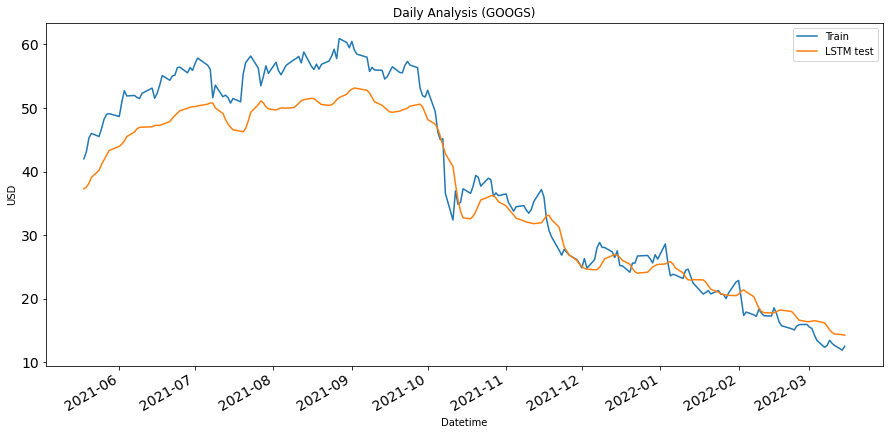

In [24]:
test.Close.plot(figsize = (15,7), label = 'Train', fontsize =14)
LSTM_test.Close.plot(figsize = (15,7), title = 'Daily Analysis (GOOGS)',
                 label = 'LSTM test', fontsize =14)

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

In [25]:
test_mse = np.reshape(test.values, (test.values.shape[0]))
LSTM_test_mse = np.reshape(LSTM_test.values, (LSTM_test.values.shape[0]))
MSE_test = mean_squared_error(test_mse, LSTM_test_mse)
MSE_test

<tf.Tensor: shape=(), dtype=float32, numpy=20.126799>

## **Forecasting:**

In [26]:
FORECAST_DAYS = 200
forecasted_lst = []

In [27]:
input_forecast = test[len(test) - LOOK_BACK :].values
input_forecast = scaler.fit_transform(input_forecast)
input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [28]:
for i in range(FORECAST_DAYS):
  forecast = model.predict(input_forecast)
  forecasted_lst.append(forecast)
  input_forecast = np.reshape(input_forecast, (input_forecast.shape[1], 1))
  input_forecast = np.concatenate((input_forecast,forecast))
  input_forecast = input_forecast[-LOOK_BACK:]
  input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))


In [29]:
forecasted_lst = np.array(forecasted_lst)
forecasted_lst = forecasted_lst.reshape((-1, 1))
forecasted_lst = scaler.inverse_transform(forecasted_lst)

In [30]:
last_test_date = test.index[-1]
initial_forecast_date = pd.date_range(last_test_date, periods = 2, freq='D' )
initial_forecast_date = initial_forecast_date[-1]
initial_forecast_date

Timestamp('2022-03-16 00:00:00', freq='D')

In [31]:
forecast_dates = pd.date_range(initial_forecast_date, periods = 
                                      FORECAST_DAYS, freq='D')


In [32]:
LSTM_forecast = pd.DataFrame(forecasted_lst, columns = ['Close'])
LSTM_forecast["Date"] = forecast_dates
LSTM_forecast.index = LSTM_forecast["Date"]
LSTM_forecast.drop("Date", axis = 1, inplace =  True)

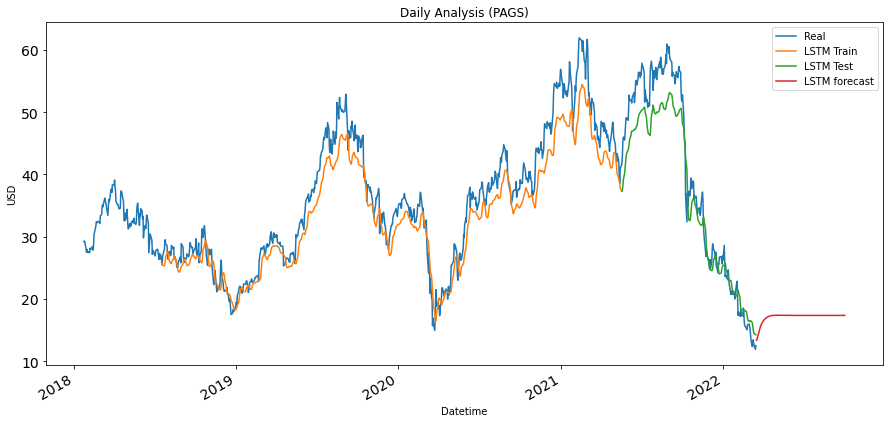

In [33]:
raw_data.Close.plot(figsize = (15,7), label = 'Real')
LSTM_train.Close.plot(figsize = (15,7), label = 'LSTM Train')
LSTM_test.Close.plot(figsize = (15,7), label = 'LSTM Test')
LSTM_forecast.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', 
                 fontsize =14, label = 'LSTM forecast')

plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')